# Visual Data Literacy - 02 - Statistical Plotting

In [2]:
# %load utils/imports.py
%matplotlib inline

import numpy as np
import pandas as pd

from utils import *
from utils.plotting import *

from utils.demo import *
from utils.styles import *

When dealing with a set of data, often the first thing you'll want to do is get a sense for how the variables are distributed. This notebook will give a brief introduction to some of the tools in seborn for examining univariate and bivariate distributions. Later we will look at examples of functions that make it easy to compare the distribution of a variable across levels of other variables.

In [3]:
# Some additional imports
from scipy import stats, integrate
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
# Seaborn Settings for colors
sns.set(color_codes=True)
mpl.rc("figure", figsize=(18, 6))
# Fixing the Random Seed
np.random.seed(0)

## Plotting univariate distributions

The most convenient way to take a quick look at a univariate distribution in seaborn is the `distplot` function. By default, this will draw a `histogram` and fit a [kernel density estimate]( https://en.wikipedia.org/wiki/Kernel_density_estimation).

In [9]:
x = np.random.normal(size=100)
sns.distplot(x);

### Histograms

A histogram represents the distribution of data by forming bins along the range of the data and then drawing bars to show the number of observations that fall in each bin. To illustrate this, let's remove the density curve and add a rug plot, which draws a small vertical tick at each observation. You can make the rug plot itself with the `rugplot` function, but it is also available in `distplot`.

In [10]:
sns.distplot(x, kde=False, rug=True);

When drawing histograms, the main choice you have is the number of bins to use and where to place them. `distplot` uses a simple rule to make a good guess for what the right number is by default, but trying more or fewer bins might reveal other features in the data:

In [11]:
sns.distplot(x, bins=20, kde=False, rug=True);

### Kernel density estimaton

The kernel density estimate can be a useful tool for plotting the shape of a distribution. Like the histogram, the KDE plots encodes the density of observations on one axis with height along the other axis:

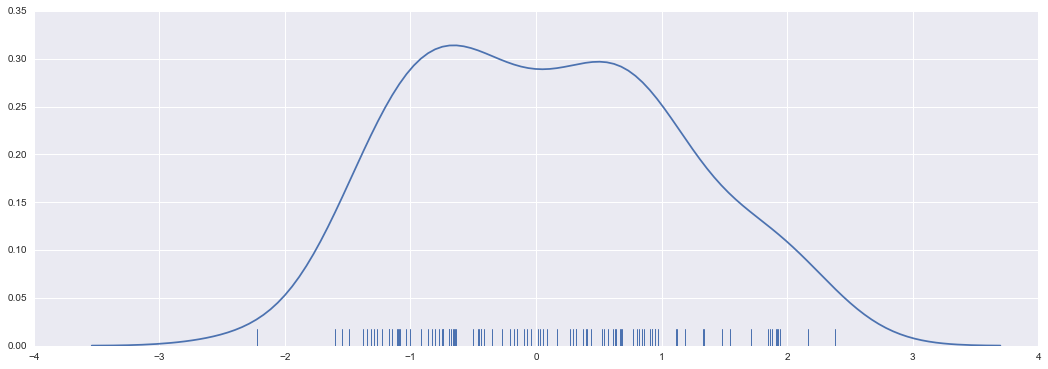

In [12]:
sns.distplot(x, hist=False, rug=True);

Drawing a KDE is more computationally involved than drawing a histogram. What happens is that each observation is first replaced with a normal (Gaussian) curve centered at that value:

In [13]:
# Generate a dataset
x = np.random.normal(0, 1, size=30)
# The bandwidth parameter of the KDE controls how tightly the estimation is fit
# to the data, much like the bin size in a histogram.
# It corresponds to the width of the kernels we plot here.
bandwidth = 1.06 * x.std() * x.size ** (-1 / 5.)
# range of evenly spaces numbers between -4 and -4 which becomes the range for the KDE
support = np.linspace(-4, 4, 200)

# actual data points around which to center the distribution
kernels = []
for x_i in x:

    kernel = stats.norm(x_i, bandwidth).pdf(support)
    kernels.append(kernel)
    plt.plot(support, kernel, color="r")

sns.rugplot(x, color=".2", linewidth=3);

Next, these curves are summed to compute the value of the density at each point in the support grid. The resulting curve is then normalized so that the area under it is equal to 1:

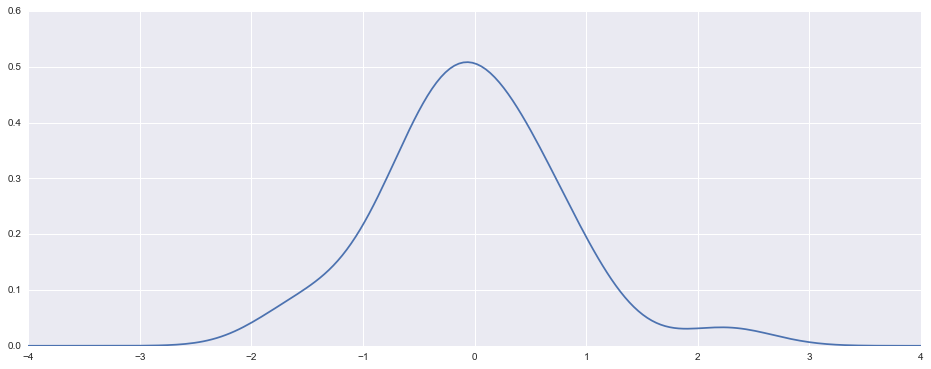

In [14]:
density = np.sum(kernels, axis=0)
density /= integrate.trapz(density, support)
plt.figure(figsize=(16, 6))
plt.plot(support, density);

We can see that if we use the `kdeplot` function in seaborn, we get the same curve. This function is used by `distplot`, but it provides a more direct interface with easier access to other options when you just want the density estimate:

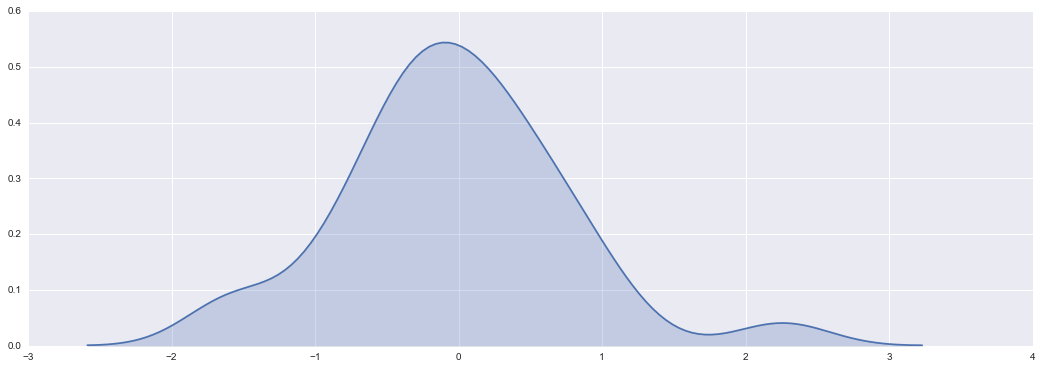

In [15]:
sns.kdeplot(x, shade=True);

### Fitting parametric distributions

You can also use `distplot` to fit a parametric distribution to a dataset and visually evaluate how closely it corresponds to the observed data:

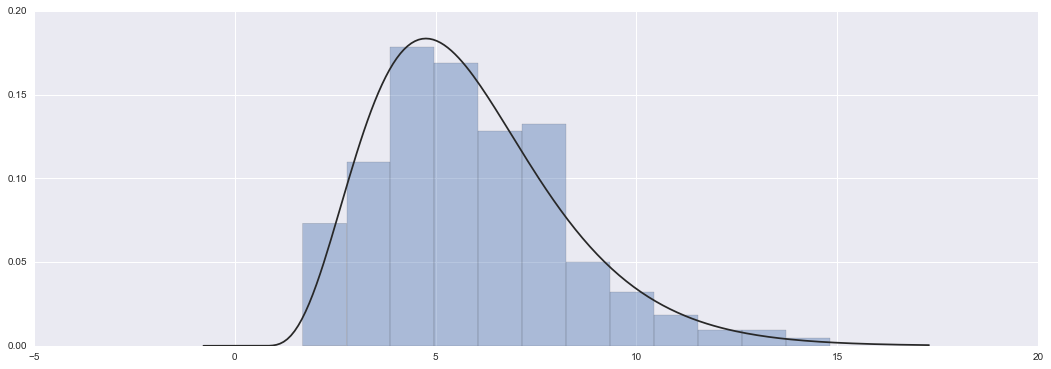

In [16]:
x = np.random.gamma(6, size=200)
sns.distplot(x, kde=False, fit=stats.gamma);

## Plotting bivariate distributions

It can also be useful to visualize a bivariate distribution of two variables. The easiest way to do this in seaborn is to just the `jointplot` function, which creates a multi-panel figure that shows both the bivariate (or joint) relationship between two variables along with the univariate (or marginal) distribution of each on separate axes.

In [17]:
mean, cov = [0, 1], [(1, .5), (.5, 1)]
data = np.random.multivariate_normal(mean, cov, 200)
df = pd.DataFrame(data, columns=["x", "y"])
grid(df.describe())

### Scatterplots

The most familiar way to visualize a bivariate distribution is a scatterplot, where each observation is shown with point at the *x* and *y* values. This is analgous to a rug plot on two dimensions. You can draw a scatterplot with the matplotlib ``plt.scatter`` function, and it is also the default kind of plot shown by the `jointplot` function:

In [18]:
sns.jointplot(x="x", y="y", data=df);

### Hexbin plots

The bivariate analogue of a histogram is known as a "hexbin" plot, because it shows the counts of observations that fall within hexagonal bins. This plot works best with relatively large datasets. It's availible through the matplotlib ``plt.hexbin`` function and as a style in `jointplot`. It looks best with a white background:

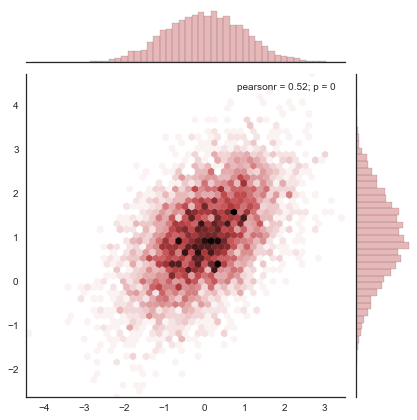

In [19]:
x, y = np.random.multivariate_normal(mean, cov, 5000).T
with sns.axes_style("white"):
    sns.jointplot(x=x, y=y, kind="hex", color="r");

### Kernel density estimation

It is also posible to use the kernel density estimation procedure described above to visualize a bivariate distribution. In seaborn, this kind of plot is shown with a contour plot and is available as a style in `jointplot`

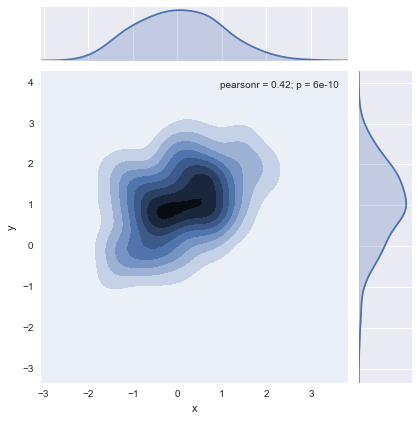

In [20]:
sns.jointplot(x="x", y="y", data=df, kind="kde");

You can also draw a two-dimensional kernel density plot with the `kdeplot` function. This allows you to draw this kind of plot onto a specific (and possibly already existing) matplotlib axes, whereas the `jointplot` function manages its own figure:

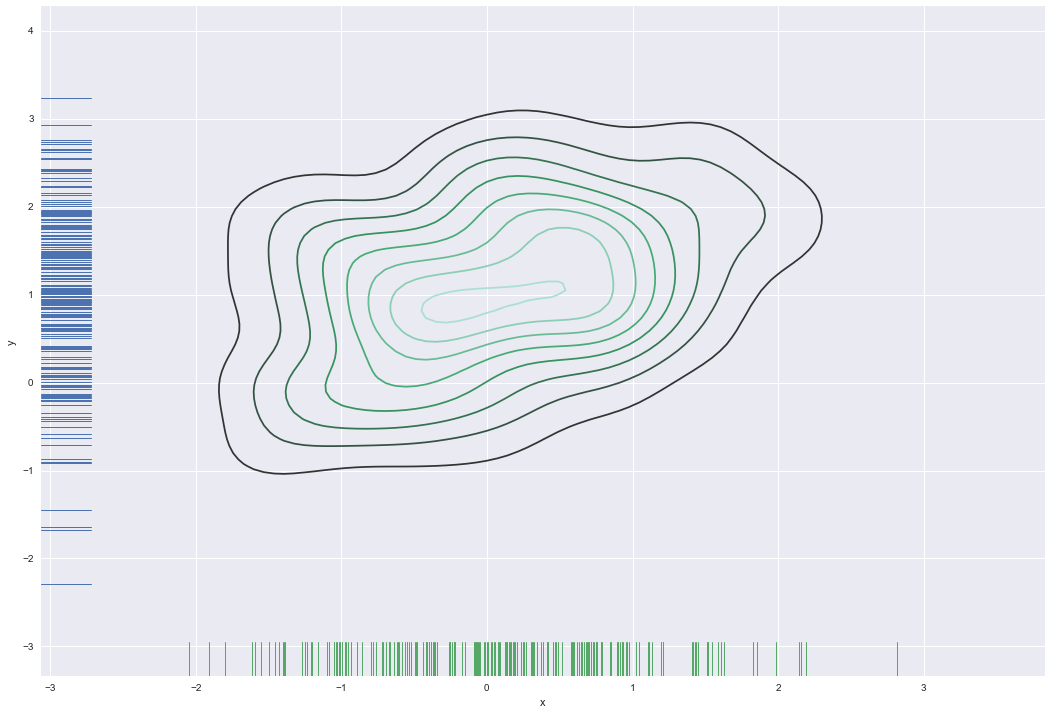

In [24]:
f, ax = plt.subplots(figsize=(18, 12))
sns.kdeplot(df.x, df.y, ax=ax)
sns.rugplot(df.x, color="g", ax=ax)
sns.rugplot(df.y, vertical=True, ax=ax);

If you wish to show the bivariate density more continuously, you can simply increase the number of contour levels:

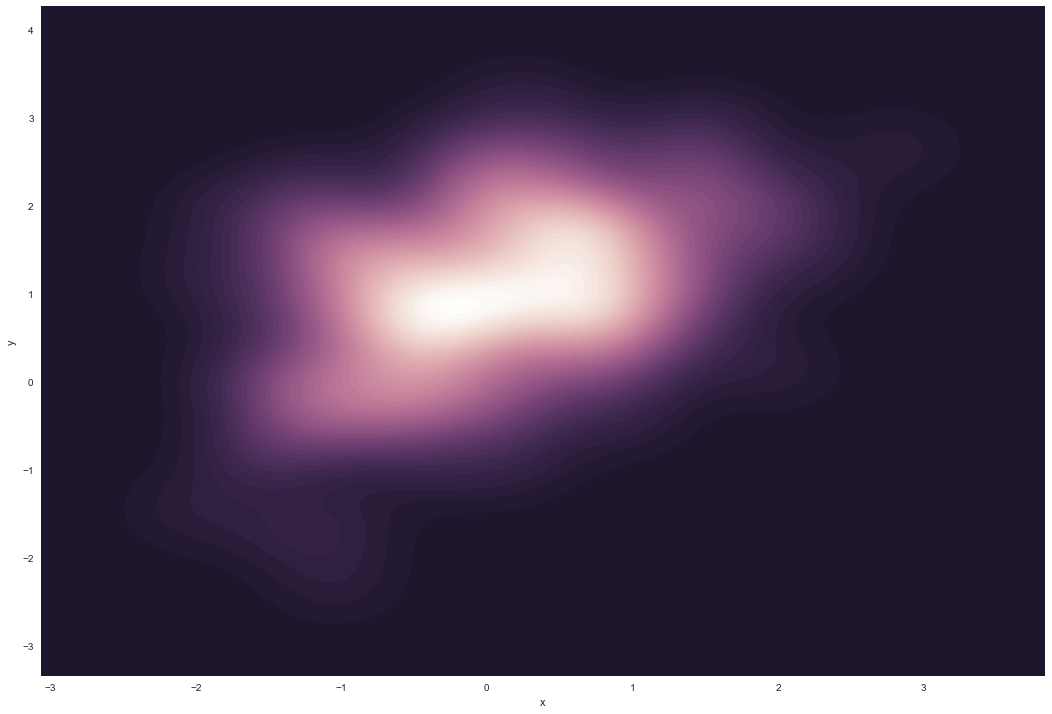

In [29]:
f, ax = plt.subplots(figsize=(18, 12))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0.1, light=1, reverse=True)
sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True);

### Visualizing pairwise relationships in a dataset

To plot multiple pairwise bivariate distributions in a dataset, you can use the `pairplot` function. This creates a matrix of axes and shows the relationship for each pair of columns in a DataFrame. by default, it also draws the univariate distribution of each variable on the diagonal Axes:

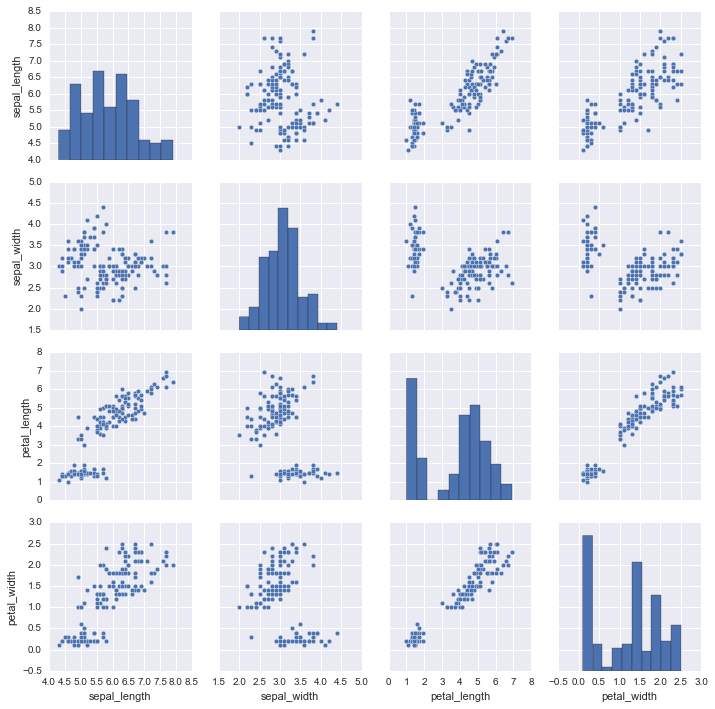

In [31]:
iris = sns.load_dataset("iris")
sns.pairplot(iris);

Much like the relationship between `jointplot` and `JointGrid`, the `pairplot` function is built on top of a `PairGrid` object, which can be used directly for more flexibility:

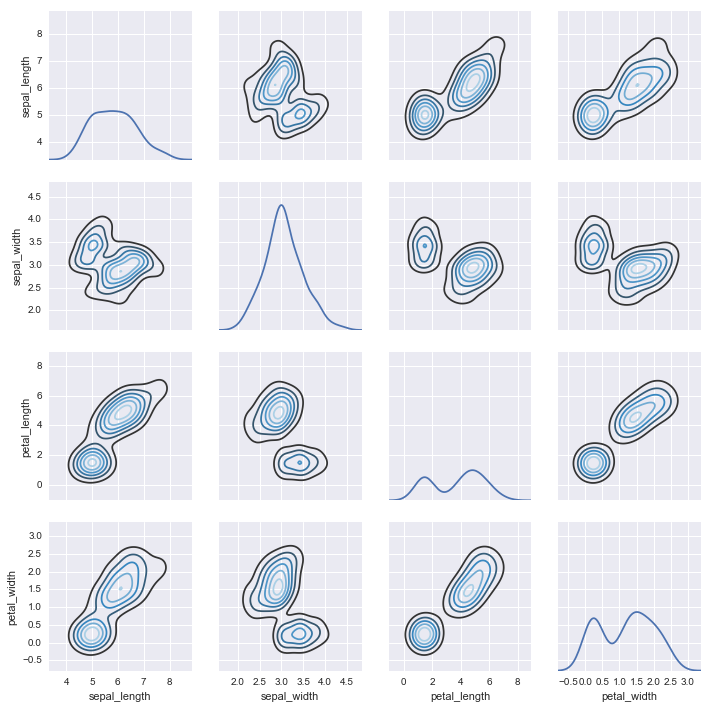

In [32]:
g = sns.PairGrid(iris)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);